# EDA for Amazon Stars vs Sentiment

---

This notebook explores the relationship between Amazon review star ratings and sentiment analysis scores. It loads a large sample of reviews, computes sentiment using DistilBERT, and visualizes the alignment (or divergence) between written sentiment and star ratings.

In [2]:
# ------------------------------------------------------------
# 0. Ensure the review slice exists, then load it
# ------------------------------------------------------------
import subprocess, pathlib, pandas as pd, sys, textwrap, os

CATEGORY = "raw_review_Clothing_Shoes_and_Jewelry"
N_ROWS   = 1_000_000

# Find the project root (the folder containing 'data' and 'notebooks')
if '__file__' in globals():
    PROJECT_ROOT = pathlib.Path(__file__).resolve().parent.parent
else:
    PROJECT_ROOT = pathlib.Path(os.getcwd()).parent
PARQUET = PROJECT_ROOT / "data" / f"{CATEGORY}_{N_ROWS}.parquet"
SCRIPT_PATH = PROJECT_ROOT / "data" / "get_data.py"

if not PARQUET.exists():
    print("🔄 Parquet not found – running data/get_data.py …")
    try:
        subprocess.run(
            [
                sys.executable,
                str(SCRIPT_PATH),
                "--category", CATEGORY,
                "--rows", str(N_ROWS)
            ],
            check=True,
            capture_output=True,
            text=True
        )
    except subprocess.CalledProcessError as e:
        print("❌ get_data.py failed")
        if e.stdout:
            print("--- get_data.py stdout ---\n" + e.stdout)
        if e.stderr:
            print("--- get_data.py stderr ---\n" + e.stderr)
        raise

    if not PARQUET.exists():
        raise FileNotFoundError("Download script finished, but Parquet still missing.")

print(f"✅ Loading {PARQUET}")
df = pd.read_parquet(PARQUET)
df.head()

rename_map = {'text': 'review_body', 'rating': 'star_rating'}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

✅ Loading c:\Users\mcnab\OneDrive\Documents\GitHub\Data-Sci-Portfolios\projects\amazon-stars-vs-sentiment\data\raw_review_Clothing_Shoes_and_Jewelry_1000000.parquet


## B. Plot star distribution → results/star_counts.png

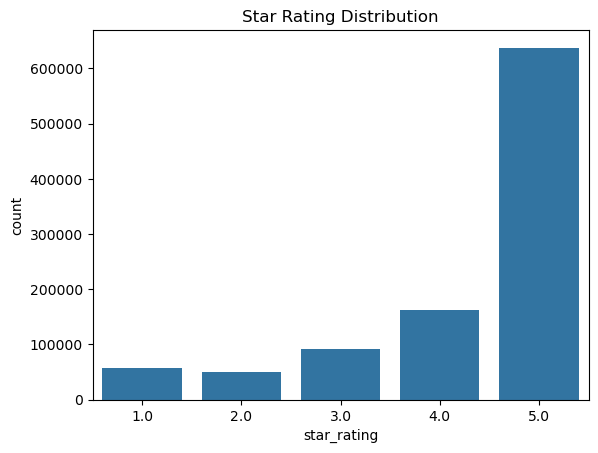

In [ ]:
import os
os.makedirs('results', exist_ok=True)
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='star_rating', data=df)
plt.title('Star Rating Distribution')
plt.savefig('results/star_counts.png')
plt.show()


## Sentiment Analysis, Divergence Metrics, and Visualizations

This block performs the main analysis and visualization steps for the Amazon Stars vs Sentiment project:
- Computes sentiment scores for each review using DistilBERT (SST-2).
- Calculates a divergence metric between the sentiment score and the normalized star rating.
- Generates and saves key figures:
  - Histogram of sentiment–star divergence.
  - Boxplot of sentiment polarity by star rating.
  - Scatterplot of helpful votes vs divergence (optional).
- Computes the Spearman correlation between helpful votes and divergence.
- Saves a cleaned subset of the data for downstream modeling.

These steps provide insight into the relationship between written sentiment and star ratings, and prepare the data for further analysis.


In [ ]:
# --------------------------------------------------
# 1⃣  Sentiment score for each review (DistilBERT)
#     – takes 2-4 min on CPU for 100k rows,
#       ~15 min for 1 M.  Adjust batch_size if RAM tight.
# --------------------------------------------------
from transformers import pipeline
import numpy as np
from tqdm.notebook import tqdm  # Use notebook version for Jupyter

sent_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,
    batch_size=64,
    device=-1               # set to 0 if you have a GPU
)

def score_batch(texts):
    res = sent_pipe(texts)
    return [1 if r["label"] == "POSITIVE" else -1 for r in res]

CHUNK_SIZE = 10_000                  # 100 batches of 10 k = 1 M rows
chunks = np.array_split(df["review_body"].values, len(df)//CHUNK_SIZE)

sent_scores = []
for chunk in tqdm(chunks, desc="Scoring", unit_scale=CHUNK_SIZE):
    sent_scores.extend(score_batch(chunk.tolist()))

df["sent_score"] = np.array(sent_scores)

# --------------------------------------------------
# 2⃣  Divergence metric & histogram (Figure 2)
# --------------------------------------------------
df["norm_star"] = (df["star_rating"] - 3) / 2        # maps 1-5 → -1…+1
df["divergence"] = df["sent_score"] - df["norm_star"]

plt.figure(figsize=(6,4))
sns.histplot(df["divergence"], bins=41, color="slateblue")
plt.axvline(0, ls="--", c="red")
plt.title("Sentiment–Star Divergence (n = 1 M)")
plt.xlabel("Divergence"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("results/divergence_hist.png")
plt.show()

# --------------------------------------------------
# 3⃣  Polarity vs star rating box-plot (Figure 3)
# --------------------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x="star_rating", y="sent_score", data=df,
            palette="Greens", showfliers=False)
plt.title("Sentiment Polarity by Star Rating")
plt.xlabel("Star Rating"); plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.savefig("results/polarity_vs_rating.png")
plt.show()

# --------------------------------------------------
# 4⃣  Helpful-votes sanity check (optional Figure 4)
# --------------------------------------------------
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["helpful_votes"].clip(upper=50),   # cap outliers for clarity
                y=df["divergence"], alpha=0.2)
plt.title("Helpful Votes vs Divergence (clipped to 50 votes)")
plt.xlabel("Helpful Votes"); plt.ylabel("Divergence")
plt.tight_layout()
plt.savefig("results/helpful_vs_divergence.png")
plt.show()

# Spearman correlation for the white-paper bullet list
from scipy.stats import spearmanr
rho, _ = spearmanr(df["helpful_votes"].fillna(0), df["divergence"])
print(f"Spearman ρ(helpful_votes, divergence) = {rho:.2f}")

# --------------------------------------------------
# 5⃣  Save cleaned subset for modelling
# --------------------------------------------------
df.to_parquet("data/clean_1M.parquet", index=False)
print("✅ Clean Parquet ready → data/clean_1M.parquet")


Device set to use cpu


Scoring:   0%|          | 0/1000000 [00:00<?, ?it/s]

## C. DistilBERT SST-2 sentiment → sent_score column

In [15]:
from transformers import pipeline
sent_clf = pipeline('sentiment-analysis')
df['sent_score'] = df['review_body'].apply(lambda x: sent_clf(x)[0]['score'])  # This may take a while!

ModuleNotFoundError: No module named 'transformers'

## D. Compute divergence metric; histogram → results/divergence_hist.png

In [17]:
df['divergence'] = df['sent_score'] - (df['star_rating']-3)/2
ax = df['divergence'].hist()
plt.title('Divergence Histogram')
plt.savefig('results/divergence_hist.png')
plt.show()

KeyError: 'sent_score'

## E. Boxplot polarity vs star rating → results/polarity_vs_rating.png

In [ ]:
sns.boxplot(x='star_rating', y='sent_score', data=df)
plt.title('Polarity vs Star Rating')
plt.savefig('results/polarity_vs_rating.png')
plt.show()

## (Optional) Helpful votes vs Divergence

In [ ]:
# sns.scatterplot(x='helpful_votes', y='divergence', data=df)
# plt.savefig('results/helpful_vs_div.png')

## F. Save cleaned subset → data/clean_1M.parquet

In [ ]:
df.to_parquet('data/clean_1M.parquet')
print('✅ Saved cleaned subset to data/clean_1M.parquet')